# **Mapping the Research Landscape of Intestinal Organoids: Trends, Topics, and Emerging Concepts**

**Objective**:
To explore thematic trends, vocabulary evolution, and emerging concepts in *intestinal organoids* research by applying **natural language processing (NLP)** to abstracts of scientific articles from PubMed.

## 0. Data Loading

In [3]:
# Load the previously saved data
import pandas as pd

df = pd.read_csv("intestinal_organoids_articles.csv")

print(df.head())

       pmid                                              title  \
0  32940424  Establishment and Culture of Human Intestinal ...   
1  35110738  Transplantation of intestinal organoids into a...   
2  30526881  Human Intestinal Organoids Maintain Self-Renew...   
3  38816841  Current applications of intestinal organoids: ...   
4  31216420  Gut organoids: mini-tissues in culture to stud...   

                                            abstract  year  
0  Human intestinal organoids derived from adult ...  2020  
1  Intestinal organoids are fundamental in vitro ...  2022  
2  Cellular diversity that shapes tissue architec...  2018  
3  In the past decade, intestinal organoid techno...  2024  
4  In vitro, cell cultures are essential tools in...  2019  


## 1. NLP Preprocessing
	- Text cleaning: remove stopwords, symbols, lowercase conversion, etc.
	- Tokenization and lemmatization (with spaCy or NLTK).

### 1.1 Defining light preprocessing function:
    - Lowercases the text
    - Removes most punctuation
    - Keeps hyphenated words intact (e.g., stem-cell stays together)
    - Splits text into words
    - Keeps only alphabetic tokens of reasonable length (3–20 characters)



In [5]:
import regex as reg

# Light preprocessing function for frequency analysis
def light_clean(text):
    text = text.lower()
    text = reg.sub(r"[.,;:!?\"\'()\[\]{}]", " ", text)
    text = reg.sub(r'(\w+)\s*-\s*(\w+)', r'\1-\2', text)
    tokens = text.split()
    tokens = [t for t in tokens if 3 <= len(t) <= 20 and t.isalpha()]
    return tokens

# Apply light_clean function to all abstracts
df["temp_cleaned"] = df["abstract"].apply(light_clean)

### 1.2. Building custom stopwords
-	Standard English stopwords (e.g. “the”, “and”, “is”)
-	Overused words
-	Domain-specific stopwords + words used for the search and download of abstracts

In [ ]:
# 🔁 Import NLP tools
from nltk.corpus import stopwords
from collections import Counter
import spacy

# 📥 Load spaCy model (run once)
nlp = spacy.load("en_core_web_sm")

# 📊 Create stopword list
stop_words = set(stopwords.words('english'))

# Compute document frequency from tokenized abstracts (after light_clean)
doc_freq = Counter()
for tokens in df["temp_cleaned"]:
    for token in set(tokens):
        doc_freq[token] += 1

# Define thresholds and domain-specific terms
threshold = 0.6 * len(df)
custom_stopwords = {word for word, freq in doc_freq.items() if freq >= threshold}
domain_stopwords = {
    "cell", "model", "study", "disease", "human", "stem", "tissue", "use",
    "barrier", "derive", "gut", "mechanism", "however", "induce"
}

# Combine all stopwords
final_stopwords = stop_words.union(custom_stopwords, domain_stopwords, {"intestinal", "organoid", "organoids"})

### 1.3. Defining the final NLP preprocessing function
-	Lowercases the text
-	Normalises hyphenated phrases
    - Uses regex to convert things like "beta - catenin" to "beta-catenin" (removes spaces around hyphens).
    - Helps preserve scientific terms that are commonly hyphenated.
-	Removes punctuation
-	Tokenizes and lemmatizes the text with spaCy
-	Keeping tokens only if:
    - It matches the regex ^[\p{L}\p{N}\-]+$ (letters, numbers, or hyphens — no symbols).
    - Its lemmatized form is not in your stopword list (stopword_set).
    - It is not a verb (based on POS tagging from spaCy).
    - Its length is between min_len and max_len (typically 3–20 characters).


In [ ]:
# Final preprocessing function: cleaning, lemmatization, and filtering
def clean_tokenize_lemmatize(text, stopword_set=None, min_len=3, max_len=20):
    if stopword_set is None:
        stopword_set = stop_words_2  # or use final_stopwords

    text = text.lower()
    
    # Replace cases like "beta - catenin" with "beta-catenin"
    # This regex detects a word + optional spaces + hyphen + optional spaces + another word
    text = reg.sub(r'(\w+)\s*-\s*(\w+)', r'\1-\2', text)
    
    # Remove basic punctuation, but preserve already-joined hyphenated words
    text = reg.sub(r"[.,;:!?\"\'()\[\]{}]", " ", text)
    
    doc = nlp(text)

    filtered = []
    for token in doc:
        lemma = token.lemma_.lower()
        
        # Keep only alphanumeric or hyphenated words
        # Filter out stopwords, verbs, and too short/long tokens
        if (reg.match(r"^[\p{L}\p{N}\-]+$", token.text) and
            lemma not in stopword_set and
            token.pos_ != "VERB" and
            min_len <= len(lemma) <= max_len):
            filtered.append(lemma)

    return filtered


In [10]:
df['cleaned_abstract'] = df['abstract'].apply(lambda x: clean_tokenize_lemmatize(x, stopword_set=final_stopwords))

In [227]:
# Save final dataframe with clean tokens
df.to_csv("pubmed_organoids_cleaned.csv", index=False)

In [ ]:
# Show some examples
print(df[['title', 'cleaned_abstract']].head())

                                               title  \
0  Establishment and Culture of Human Intestinal ...   
1  Transplantation of intestinal organoids into a...   
2  Human Intestinal Organoids Maintain Self-Renew...   
3  Current applications of intestinal organoids: ...   
4  Gut organoids: mini-tissues in culture to stud...   

                                    cleaned_abstract  
0  [adult, miniature, vivo, version, epithelium, ...  
1  [fundamental, vitro, tool, new, research, oppo...  
2  [cellular, diversity, architecture, function, ...  
3  [past, decade, technology, way, morphogenesis,...  
4  [vitro, culture, essential, tool, function, pa...  


## 2. Exploratory Data Analysis (EDA)
Generating word clouds with the most frequent tokens.


### 2.1. Unigram WordCloud

/var/folders/rt/xkq46lm17mvfngfb_71vnbnc0000gn/T/ipykernel_55161/610410401.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Blues')


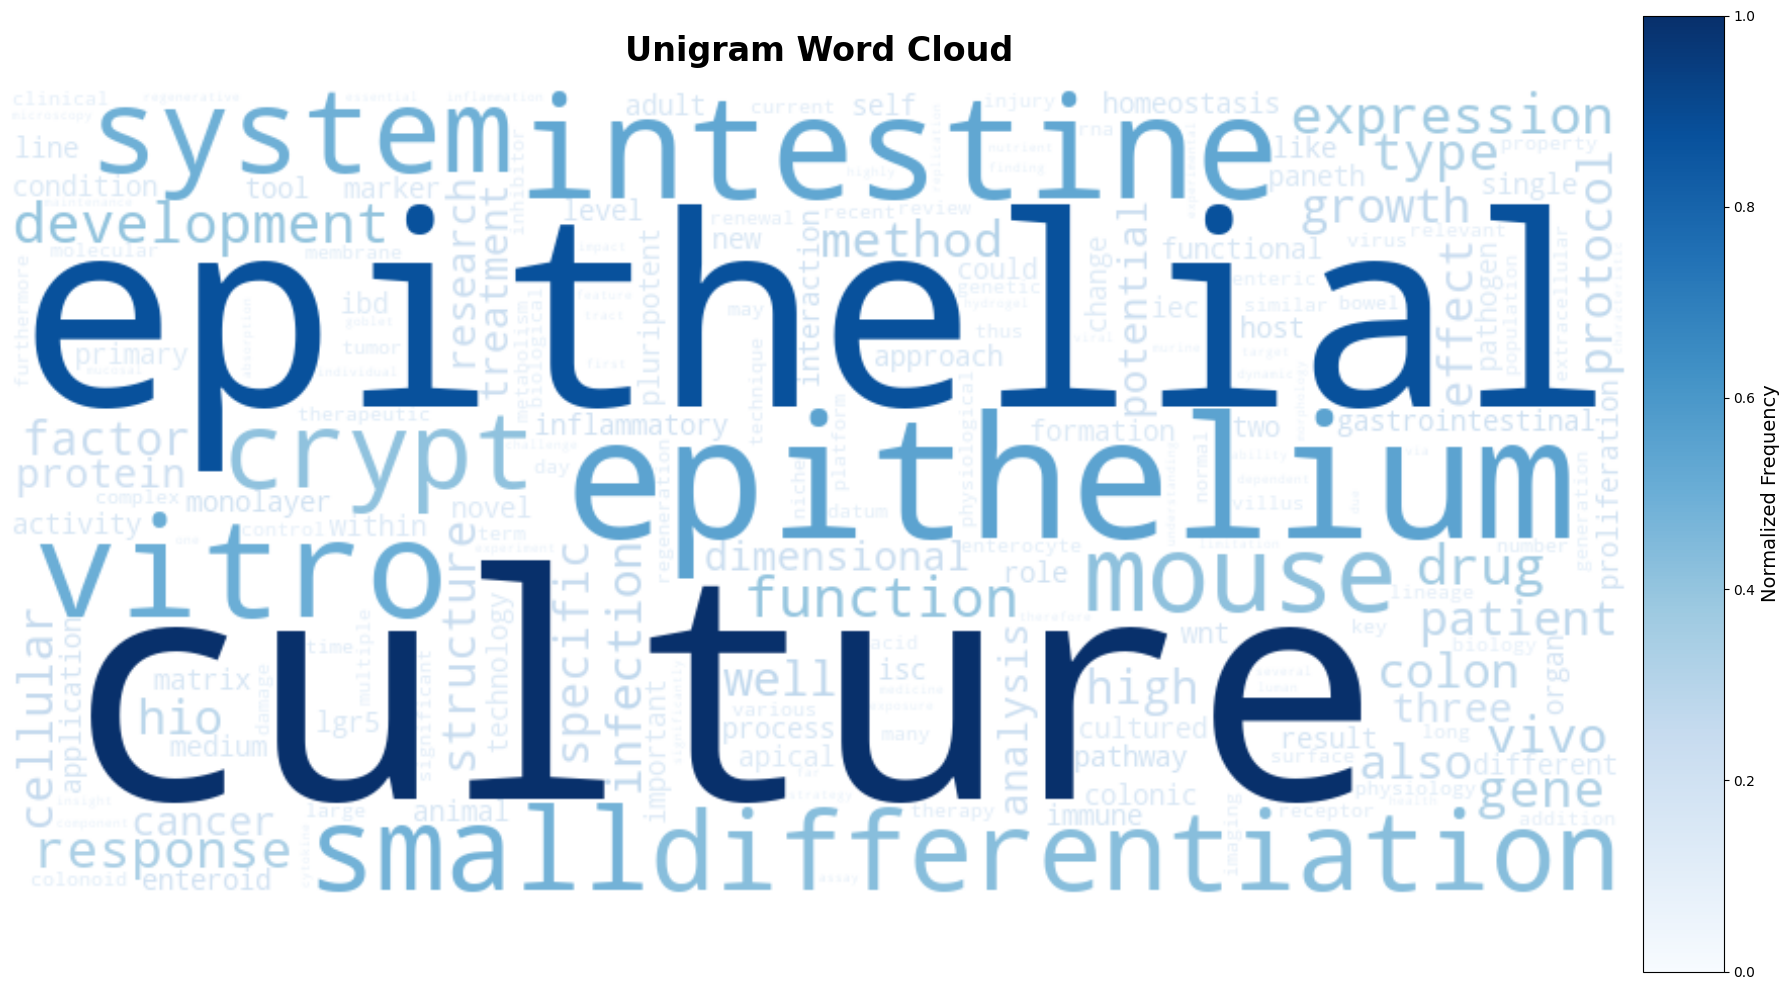

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar, colors
from collections import Counter

# Compile all words into one big list
all_words = [word for abstract in df['cleaned_abstract'] for word in abstract]

# Count word frequencies
word_freq = Counter(all_words)

# Normalize frequencies (0 to 1)
max_freq = max(word_freq.values())
norm_freqs = {word: freq / max_freq for word, freq in word_freq.items()}

# Choose a colormap
colormap = cm.get_cmap('Blues')

# Define custom color function
def color_func(word, font_size, position, orientation, font_path, random_state):
    freq = norm_freqs.get(word, 0)
    r, g, b, _ = colormap(freq)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

# Generate the WordCloud
wc = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(word_freq)

# Plot WordCloud
fig, ax = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 0.2]})

# WordCloud image
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Unigram Word Cloud", fontsize=24, fontweight='bold', pad=20)

# Colorbar as legend
norm = colors.Normalize(vmin=0, vmax=1)
cb = colorbar.ColorbarBase(ax[1], cmap=colormap, norm=norm, orientation='vertical')
cb.set_label('Normalized Frequency', fontsize=14)

plt.tight_layout()
plt.show()

Displaying the word cloud of most frequent words, we see that *most of the words don't really mean anything*: <ins>culture, epithelial, epithelium, intestine, system...</ins> They are intrinsically related to "intestinal organoids".

To solve this, we can **fine-tune again the list of stop words**, or we can **do the tokenization by bigrams**, so instead of having cell, or disease, we will have, cell line, or intestinal disease.

### 2.2. Bigrams and Trigrams' WordClouds

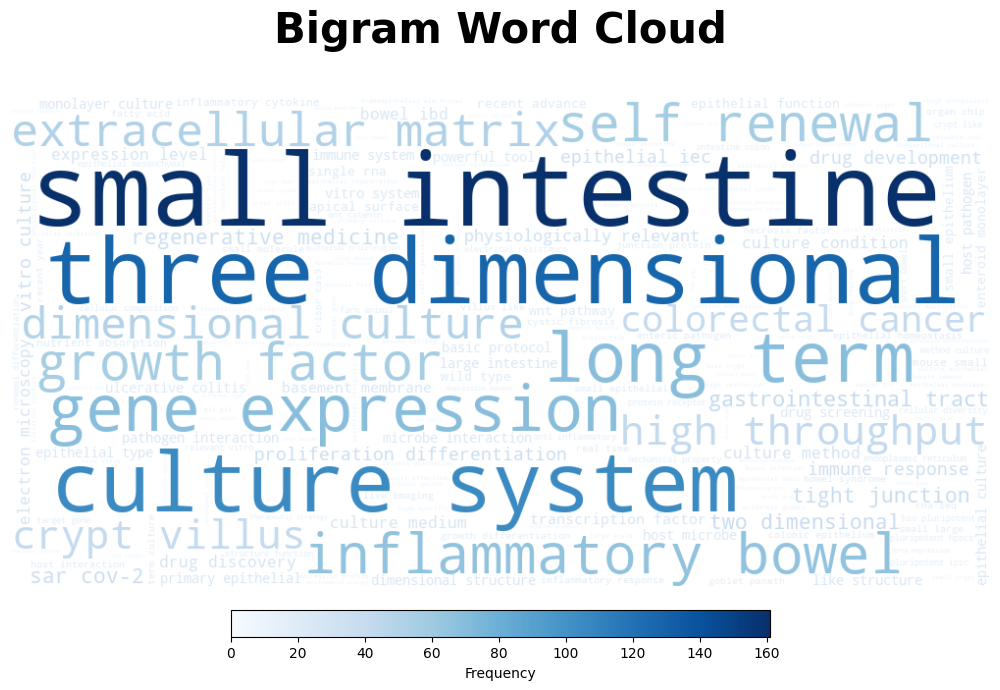

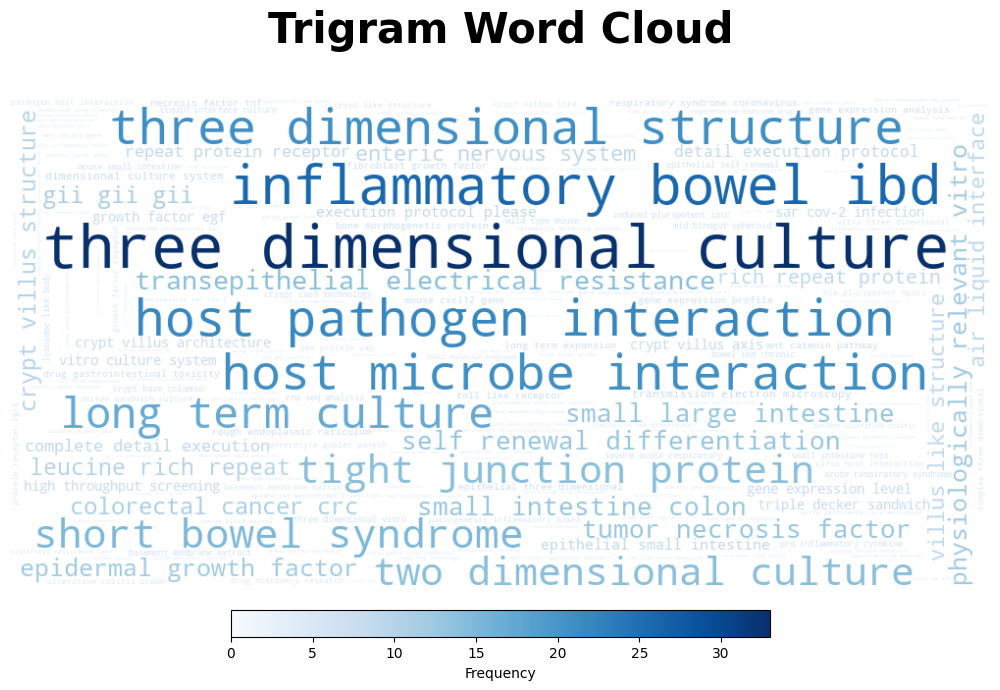

In [17]:
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter

# Combine all cleaned tokens from all abstracts into one list
all_tokens = [token for abstract in df["cleaned_abstract"] for token in abstract]

# Generate bigrams and trigrams
bigrams = list(ngrams(all_tokens, 2))
trigrams = list(ngrams(all_tokens, 3))

# Count frequencies
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Convert ngram tuples to strings
bigram_strings = {' '.join(k): v for k, v in bigram_freq.items()}
trigram_strings = {' '.join(k): v for k, v in trigram_freq.items()}

# Normalize frequencies (0 to 1)
max_bigram = max(bigram_strings.values())
max_trigram = max(trigram_strings.values())

# Colormap
cmap = matplotlib.colormaps['Blues']

# Color function factory
def make_color_func(freq_dict, max_freq, cmap):
    def color_func(word, font_size, position, orientation, font_path, random_state):
        freq = freq_dict.get(word, 0)
        norm_val = freq / max_freq
        r, g, b, _ = cmap(norm_val)
        return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"
    return color_func

color_func_bigram = make_color_func(bigram_strings, max_bigram, cmap)
color_func_trigram = make_color_func(trigram_strings, max_trigram, cmap)

# Plot Bigram WordCloud with colorbar
fig, ax = plt.subplots(figsize=(15, 7))
wc_bigram = WordCloud(width=1000, height=500, background_color='white', color_func=color_func_bigram).generate_from_frequencies(bigram_strings)
ax.imshow(wc_bigram, interpolation='bilinear')
ax.set_title("Bigram Word Cloud", fontsize=30, fontweight='bold', pad=40)
ax.axis('off')

# Add colorbar below the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=max_bigram))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('Frequency')

plt.show()

# Plot Trigram WordCloud with colorbar
fig, ax = plt.subplots(figsize=(15, 7))
wc_trigram = WordCloud(width=1000, height=500, background_color='white', color_func=color_func_trigram).generate_from_frequencies(trigram_strings)
ax.imshow(wc_trigram, interpolation='bilinear')
ax.set_title("Trigram Word Cloud", fontsize=30, fontweight='bold', pad=40)
ax.axis('off')

# Add colorbar below the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=max_trigram))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('Frequency')

plt.show()

### 2.3 Word2Vec

**Word2Vec** is a model that learns vector representations of words based on their context in a text corpus. Words with similar meanings end up with similar vectors.

- Trained a Word2Vec model using `gensim` on light-cleaned abstracts (non-lemmatized).
- Captures semantic relationships based on word co-occurrence.
- Used t-SNE for dimensionality reduction.
- Visualized clusters of related terms (e.g., stem cells, inflammation).

In [18]:
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = df['temp_cleaned'].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimensionality of the word vectors
    window=10,          # maximum distance between current and predicted word
    min_count=3,       # ignores words with total frequency lower than this
    workers=4,         # number of CPU cores to use
    sg=1               # 1 = skip-gram; 0 = CBOW
)

In [ ]:
# Get most similar words to "epithelial"
w2v_model.wv.most_similar("epithelial", topn=10)
print("Most similar words to 'epithelial':", w2v_model.wv.most_similar("epithelial", topn=10))

[('layer', 0.8447427153587341),
 ('epithelia', 0.8310995101928711),
 ('muscle', 0.8259401917457581),
 ('respond', 0.8189800977706909),
 ('compartment', 0.818138837814331),
 ('iecs', 0.8131113648414612),
 ('mucosa', 0.8066208958625793),
 ('lining', 0.8065155744552612),
 ('characterized', 0.8033179640769958),
 ('continuously', 0.803011417388916)]

In [ ]:
# Similar words to "barrier"
w2v_model.wv.most_similar("wnt", topn=10)
print("Most similar words to 'wnt':", w2v_model.wv.most_similar("wnt", topn=10))

[('notch', 0.9400525689125061),
 ('signaling', 0.925615668296814),
 ('pathway', 0.9207676649093628),
 ('bmp', 0.9169959425926208),
 ('pathways', 0.902427613735199),
 ('transcription', 0.8759788274765015),
 ('enhances', 0.8662098050117493),
 ('tumorigenesis', 0.857989490032196),
 ('morphogenetic', 0.8461827635765076),
 ('activated', 0.8372529745101929)]

In [21]:
# Similarity score between two words
w2v_model.wv.similarity("epithelial", "wnt")

0.35085404

In [1]:
# Reduce dimensionality with t-SNE and plot
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

#Define cleaned sentences for visualization
cleaned_sentences = df['cleaned_abstract'].tolist()

# Get the top N most frequent words
top_n = 100
word_freq = Counter([word for sent in cleaned_sentences for word in sent])
top_words = [word for word, freq in word_freq.most_common(top_n) if word in w2v_model.wv]

# Get the word vectors
word_vectors = np.array([w2v_model.wv[word] for word in top_words])

# t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=5000)
word_vecs_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], c='skyblue')

for i, word in enumerate(top_words):
    plt.annotate(word, xy=(word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9)

plt.title("2D t-SNE Visualization of Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

This t-SNE plot shows a 2D projection of word embeddings learned by the Word2Vec model.
Words that appear in similar biological contexts — such as stem, differentiation, and pluripotent — are clustered together, revealing thematic structures in the corpus.

## 3. Topic Modelling using LDA (Latent Dirichlet Allocation)

In this section, we apply **Latent Dirichlet Allocation (LDA)** to uncover the main research themes in the corpus of abstracts. LDA is an unsupervised machine learning technique that identifies *groups of words (topics) that frequently occur together* across documents. This helps us explore hidden thematic structures and understand the main areas of focus within the scientific literature on intestinal organoids. Then, we can assign topics to articles by year to analyze their evolution.


In [23]:
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd

# Prepare the data for LDA
# Step 1: Create a dictionary from the cleaned abstracts
dictionary = corpora.Dictionary(df["cleaned_abstract"])

# Step 2: Filter extremes (optional but useful)
dictionary.filter_extremes(no_below=2, no_above=0.9)

# Step 3: Create the bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in df["cleaned_abstract"]]

In [24]:
# Train LDA model
# Set number of topics (e.g., 5 or 6)
num_topics = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [25]:
# Print keywords for each topic
for i, topic in lda_model.show_topics(num_words=10, formatted=False):
    keywords = ", ".join([word for word, prob in topic])
    print(f"Topic {i}: {keywords}")

Topic 0: epithelial, mouse, expression, culture, crypt, intestine, function, small, isc, gene
Topic 1: system, culture, epithelium, vitro, hio, differentiation, intestine, response, development, epithelial
Topic 2: culture, epithelial, patient, protocol, drug, ibd, inflammatory, hio, response, expression
Topic 3: epithelial, culture, small, type, intestine, matrix, differentiation, method, mouse, paneth
Topic 4: culture, epithelial, system, vitro, epithelium, infection, drug, research, development, gastrointestinal


### 🧠 Topic Modeling Interpretation

Based on the top keywords per topic, here is an interpretation of each theme extracted from the abstracts:

---

🔹 **Topic 0 – Gene expression and stem cell function in mouse intestinal models**  
**Keywords:** epithelial, mouse, expression, culture, crypt, intestine, function, small, isc, gene

This topic reflects studies focused on **mouse intestinal models**, investigating **gene expression**, **epithelial function**, and **intestinal crypts**, especially related to **intestinal stem cells (ISCs)**.

➡️ Research includes intestinal epithelial regeneration, development, and gene function in animal-derived in vitro systems.

---

🔹 **Topic 1 – In vitro systems for epithelial differentiation and development**  
**Keywords:** system, culture, epithelium, vitro, hio, differentiation, intestine, response, development, epithelial

This topic addresses **in vitro systems**, such as **human intestinal organoids (HIOs)**, used to study **epithelial differentiation** and **development**.

➡️ Emphasis is on 3D cultures modeling intestinal development and epithelial responses under controlled lab conditions.

---

🔹 **Topic 2 – Patient-derived organoids for IBD and drug testing**  
**Keywords:** culture, epithelial, patient, protocol, drug, ibd, inflammatory, hio, response, expression

This topic focuses on **patient-derived organoids**, especially in the context of **inflammatory bowel disease (IBD)**.

➡️ It includes drug testing, clinical protocol optimization, and studies of inflammatory responses in personalized organoid models.

---

🔹 **Topic 3 – Regional identity and structural aspects of small intestinal epithelium**  
**Keywords:** epithelial, culture, small, type, intestine, matrix, differentiation, method, mouse, paneth

This topic highlights **regional identity** of the **small intestine epithelium** and **structural components** such as the **extracellular matrix**.

➡️ Studies also explore specific cell types like **Paneth cells** and differentiation methods in both mouse and human models.

---

🔹 **Topic 4 – Infection models and drug response in gastrointestinal systems**  
**Keywords:** culture, epithelial, system, vitro, epithelium, infection, drug, research, development, gastrointestinal

This topic involves epithelial systems used to model **gastrointestinal infections** and evaluate **drug responses**.

➡️ It covers pathogen-host interaction studies and translational research to understand epithelial responses to infections in vitro.

In [26]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.068970  0.034991       1        1  25.766439
1      0.029401 -0.027661       2        1  23.679694
4      0.108922  0.001714       3        1  20.336289
2     -0.017841  0.076442       4        1  16.301635
3     -0.051513 -0.085486       5        1  13.915943, topic_info=            Term        Freq       Total Category  logprob  loglift
566          hio  218.000000  218.000000  Default  30.0000  30.0000
458          ibd  100.000000  100.000000  Default  29.0000  29.0000
288          isc  146.000000  146.000000  Default  28.0000  28.0000
183      patient  210.000000  210.000000  Default  27.0000  27.0000
64    epithelial  685.000000  685.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
220         gene   29.122195  254.818730   Topic5  -5.6133  -0.1969
162  development   28.715863  319.068465   Topic5  -5.6273  -0.4358
214        crypt   26.655377  321.909737   Topic5  -5.7018  -0.5191
196       system   27.083712  393.146905   Topic5  -5.6859  -0.7031
164         drug   25.558360  287.021009   Topic5  -5.7438  -0.4465

[413 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1599      4  0.825730     001
2275      3  0.811036    2009
2755      5  0.818195    2016
2999      3  0.951519    ace2
271       2  0.915059     ach
...     ...       ...     ...
2661      3  0.121472  wnt-3a
2661      4  0.850304  wnt-3a
1458      1  0.812037     wrn
1458      5  0.124929     wrn
889       1  0.940523    yap1

[873 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

This pyLDAvis plot allows to interactively explore LDA topics, showing the distance between them and the most relevant terms per topic.

## 4. Temporal Analysis

In this final section, I explore how publication trends — and thematic focus — have evolved over time.

### 4.1. Year variable preprocessing

In [286]:
# Convert 'year' column to numeric, coercing errors to NaN
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Optionally drop rows with no year
df = df.dropna(subset=['year'])

# Convert year to integer
df['year'] = df['year'].astype(int)

In [289]:
# Group by year and count publications
pubs_per_year = df.groupby('year').size().reset_index(name='counts')

# Calculate percentage of total publications per year
pubs_per_year['percentage'] = (pubs_per_year['counts'] / pubs_per_year['counts'].sum()) * 100

### 📊 Temporal Analysis of Publications


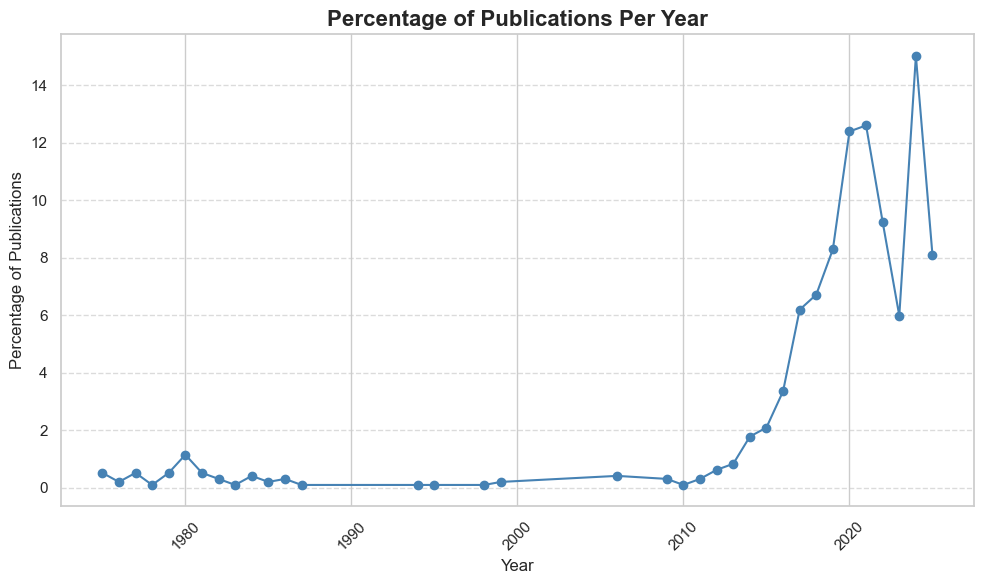

In [290]:
import matplotlib.pyplot as plt

# Line chart showing number of publications per year
plt.figure(figsize=(10, 6))
plt.plot(pubs_per_year['year'], pubs_per_year['percentage'], marker='o', linestyle='-', color='steelblue')

plt.title('Percentage of Publications Per Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Publications', fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Plot showing the number of publications per year to observe growth in the intestinal organoid field over time.

### 4.2. Temporal Topic Modeling (LDA by year)

In [27]:
# Step 1: Assign topics to abstracts
# Get topic distribution for each document
topic_assignments = []
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc)
    # Assign the topic with highest probability
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    topic_assignments.append(dominant_topic)

# Assign to DataFrame
df['dominant_topic'] = topic_assignments

In [37]:
# Step 2: Count topics per year
topic_year_counts = df.groupby(['year', 'dominant_topic']).size().reset_index(name='count')

# Count total publications per year
total_per_year = df.groupby('year').size().reset_index(name='total_articles')

# Merge total publications with topic counts
topic_year_counts = topic_year_counts.merge(total_per_year, on='year')

# Calculate proportion of articles per topic per year
topic_year_counts['proportion'] = topic_year_counts['count'] / topic_year_counts['total_articles']

# Dictionary with topic names
topic_names = {
    0: "Gene expression and stem cell function in mouse intestinal models",
    1: "In vitro systems for epithelial differentiation and development",
    2: "Patient-derived organoids for IBD and drug testing",
    3: "Regional identity and structural aspects of small intestinal epithelium",
    4: "Infection models and drug response in gastrointestinal systems"
}

# Map the topic names
topic_year_counts['topic_name'] = topic_year_counts['dominant_topic'].map(topic_names)

First, we've visualized the **absolute number of articles per topic over time** to assess the overall growth of each research line. Now, we examine the **relative importance of each topic using proportions and linear trendlines**, which help reveal which topics are gaining or losing prominence over the years.

### 4.2.1. Number of Articles per Topic by Year

In [ ]:
import pandas as pd
import numpy as np

# Create all possible year-topic combinations
years = topic_year_counts['year'].unique()
topics = topic_year_counts['dominant_topic'].unique()
all_combinations = pd.MultiIndex.from_product([years, topics], names=['year', 'dominant_topic']).to_frame(index=False)

# Merge with the original data to ensure all combinations are present
topic_year_counts_full = all_combinations.merge(topic_year_counts, on=['year', 'dominant_topic'], how='left')

# Fill missing values with 0 or appropriate total
topic_year_counts_full['count'] = topic_year_counts_full['count'].fillna(0)
topic_year_counts_full['total_articles'] = topic_year_counts_full['total_articles'].fillna(
    topic_year_counts_full.groupby('year')['total_articles'].transform('first')
)
topic_year_counts_full['proportion'] = topic_year_counts_full['count'] / topic_year_counts_full['total_articles']

# Map topic numbers to topic names
topic_year_counts_full['topic_name'] = topic_year_counts_full['dominant_topic'].map(topic_names)

# Sort by year and topic
topic_year_counts_full = topic_year_counts_full.sort_values(['year', 'dominant_topic']).reset_index(drop=True)

In [46]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # Set default renderer to open in browser

# Define topic order and consistent color map (ha de coincidir amb l'altre gràfic)
ordered_topics = [
    "Gene expression and stem cell function in mouse intestinal models",
    "In vitro systems for epithelial differentiation and development",
    "Patient-derived organoids for IBD and drug testing",
    "Regional identity and structural aspects of small intestinal epithelium",
    "Infection models and drug response in gastrointestinal systems"
]

# Assign consistent colors manually
color_palette = px.colors.qualitative.Plotly
topic_color_map = {topic: color_palette[i] for i, topic in enumerate(ordered_topics)}

# Plot the line chart with consistent colors
fig = px.line(
    topic_year_counts,
    x='year',
    y='count',  # absolute count of articles
    color='topic_name',
    markers=True,
    title='Number of Articles per Topic by Year',
    labels={
        'year': 'Year',
        'count': 'Number of Articles',
        'topic_name': 'Topic'
    },
    category_orders={'topic_name': ordered_topics},
    color_discrete_map=topic_color_map,
    width=1000,
    height=600
)

# Customizing legend and putting it below the plot
fig.update_layout(
    legend=dict(
        orientation="v",
        yanchor="top",
        y=-0.1,
        xanchor="center",
        x=0.5
    ),
    template='plotly_white'
)

fig.show()

This plot presents the absolute number of publications assigned to each topic for every year in the dataset.

- The y-axis shows the **number of articles** published per topic.
- Each colored line represents a different topic, allowing us to observe how research activity within each theme changes over time.
- The legend below the plot ensures consistent topic-color mapping across all visualizations.

This overview helps understand the volume and distribution of research output by topic through the years.

### 4.2.2. Stacked Bar Chart for Topic Distribution Over Years



In [47]:
import plotly.express as px

# Use the complete DataFrame with zeros filled for missing topic-year combinations
df_plot = topic_year_counts_full.sort_values(['year', 'proportion'], ascending=[True, False])

fig = px.bar(
    df_plot,
    x='year',
    y='proportion',
    color='topic_name',
    color_discrete_map=topic_color_map,
    title='Proportion of Topics per Year (Stacked Bar Chart)',
    labels={'year': 'Year', 'proportion': 'Proportion of Articles', 'topic_name': 'Topic'},
    width=1000,
    height=600
)

fig.update_layout(
    legend=dict(
        orientation="v",
        yanchor="top",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    template='plotly_white',
    xaxis=dict(tickmode='linear')
)

fig.show()

Stacked bar chart showing the relative proportion of each topic across years.
This helps visualize how thematic focus shifts over time.

### 4.2.3. Trend Lines of Topic Proportions Over Time

This plot shows the temporal trends of the relative importance of each topic in the corpus, normalized by the total number of publications each year. 

- The y-axis represents the **proportion of articles** attributed to each topic per year.
- The lines correspond to **linear regression fits**, highlighting the general increase or decrease in the prominence of each topic over time.
- Colors are consistent across all visualizations for easy comparison.

This visualization helps to identify emerging or declining research themes within the dataset throughout the years.

In [48]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Use the complete dataframe
df_line = topic_year_counts_full.copy()

# Create a color map for dominant_topic integers using topic_color_map (which uses topic names)
color_map = {k: topic_color_map[v] for k, v in topic_names.items()}

# Create base line chart
fig = px.line(
    df_line,
    x='year',
    y='proportion',
    color='dominant_topic',
    color_discrete_map=color_map,
    markers=True,
    labels={
        'year': 'Year',
        'proportion': 'Proportion of Articles',
        'dominant_topic': 'Topic'
    },
    title='Topic Proportions Over Years with Trend Lines',
    width=1000,
    height=800
)

# Rename legend entries with full topic names
for i, topic_num in enumerate(sorted(df_line['dominant_topic'].unique())):
    fig.data[i].name = topic_names[topic_num]

# Add trend lines (linear regression) for each topic
for topic in sorted(df_line['dominant_topic'].unique()):
    subset = df_line[df_line['dominant_topic'] == topic].sort_values('year')
    x = subset['year'].values
    y = subset['proportion'].values

    # Only fit regression if there's more than one point
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)(x)

        fig.add_trace(go.Scatter(
            x=x,
            y=trend,
            mode='lines',
            name=f"{topic_names[topic]} (Trend)",
            line=dict(color=color_map[topic], dash='dash'),
            showlegend=True
        ))

# Customize layout
fig.update_layout(
    legend=dict(
        orientation="v",
        yanchor="top",
        y=-0.1,  # Put below the plot (adjust as needed)
        xanchor="center",
        x=0.5
    ),
    template='plotly_white',
    xaxis=dict(range=[df_line['year'].min() - 1, df_line['year'].max() + 1])
)

fig.show()

Line chart showing the evolution of each topic’s share across time.
It highlights growth or decline in interest for specific topics.

## 5. Conclusion

In this project, I explored the scientific literature on intestinal organoids using Natural Language Processing techniques.

Starting from a collection of abstracts retrieved from PubMed, I applied standard and domain-specific preprocessing, trained a Word2Vec model to uncover semantic relationships, and used topic modeling (LDA) to identify latent themes. I also analyzed how these topics are distributed across the literature.

Finally, a temporal analysis showed not only the sharp increase in publications over the past decade, but also a shift in research focus — from early studies on gene expression in mouse models to emerging interest in epithelial regeneration, barrier function, and patient-derived systems.

This project illustrates how combining domain expertise with data science tools can yield insights from unstructured scientific texts — and opens up possibilities for integrating such methods into future research workflows.